In [ ]:
%pip install langgraph graphviz langchain langchain_ollama --q
%pip install langchain-openai langchain_community --q


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
# import networkx as nx
# import matplotlib.pyplot as plt

from typing import TypedDict, Optional
from langchain.chat_models import ChatOpenAI
from langchain_ollama import OllamaLLM
from langchain.schema import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
import json
import re
from typing_extensions import Annotated
import os
from dotenv import load_dotenv

In [35]:
load_dotenv()

# Ollama
# llm = OllamaLLM(model=os.getenv("OLLAMA_MODEL"), base_url=os.getenv("OLLAMA_BASE_URL"))

# NTTH
from genai_wrapper import NTTHWrapperChatLLM
llm = NTTHWrapperChatLLM(
    id=os.getenv("NTTH_ID"),
    secret=os.getenv("NTTH_SECRET"),
    model_name=os.getenv("NTTH_MODEL"),
    provider=os.getenv("NTTH_PROVIDER"),
    base_url=os.getenv("NTTH_BASE_URL")
)

# OpenAI
# MODEL = os.getenv("MODEL")
# OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
# llm = ChatOpenAI(model=MODEL, openai_api_key=OPENAI_API_KEY, temperature=0.2)

In [36]:
# # Step 1: Define the State Schema
class PrototypeState(TypedDict):
    input_requirements: Annotated[str, "single"]
    frontend_spec: Annotated[Optional[str], "multi"]
    backend_spec: Annotated[Optional[str], "multi"]
    frontend_code: Annotated[Optional[str], "multi"]
    backend_code: Annotated[Optional[str], "multi"]
    frontend_valid: Annotated[bool, "multi"]
    backend_valid: Annotated[bool, "multi"]
    frontend_feedback: Annotated[Optional[str], "multi"]
    backend_feedback: Annotated[Optional[str], "multi"]
    frontend_attempts: Annotated[int, "multi"]  # Tracks frontend iterations
    backend_attempts: Annotated[int, "multi"]  # Tracks backend iterations
    deployment_ready: Annotated[bool, "multi"]

def get_llm_response(llm, prompt):
    """Helper function to handle different LLM response formats"""
    response = llm.invoke(prompt)
    if isinstance(llm, ChatOpenAI):
        return response.content
    elif isinstance(llm, NTTHWrapperChatLLM):
        response = llm.invoke([HumanMessage(content=prompt)])
        return response.content
    return response

def extract_section(text: str, section: str) -> str:
    """Extracts frontend/backend sections from LLM response using regex."""
    pattern = rf"{section}.*?:\s*(.*?)(?=\n\n|$)"  # Matches until next blank line or end
    match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
    return match.group(1).strip() if match else f"Error extracting {section} specifications."

def frontend_requirement_agent(state: PrototypeState) -> PrototypeState:
    """Extracts frontend-specific requirements manually (without JSON)."""
    prompt = f"""
    You are a software architect. Extract only the FRONTEND specifications from the given project requirements.

    **Ensure your response follows this format:**
    Frontend Specifications:
    - Item 1
    - Item 2
    - ...

    **Project Requirements:** {state['input_requirements']}
    """
    
    response = get_llm_response(llm, prompt)
    frontend_spec = extract_section(response, "Frontend Specifications")
    
    return {"frontend_spec": frontend_spec}

def backend_requirement_agent(state: PrototypeState) -> PrototypeState:
    """Extracts backend-specific requirements manually (without JSON)."""
    prompt = f"""
    You are a software architect. Extract only the BACKEND specifications from the given project requirements.

    **Ensure your response follows this format:**
    Backend Specifications:
    - Item 1
    - Item 2
    - ...

    **Project Requirements:** {state['input_requirements']}
    """
    
    response = get_llm_response(llm, prompt)
    backend_spec = extract_section(response, "Backend Specifications")
    
    return {"backend_spec": backend_spec}

# Step 3: Development & Validation Agents (Same as before)
def frontend_agent(state: PrototypeState) -> PrototypeState:
    """Generates frontend code based on specifications using LLM."""
    prompt = f"""
    You are a frontend developer. Write a clean, modular frontend component based on the following specifications:
    
    {state['frontend_spec']}
    
    Ensure the code follows best practices.
    """
    return {"frontend_code": get_llm_response(llm, prompt)}

def backend_agent(state: PrototypeState) -> PrototypeState:
    """Generates backend code based on specifications using LLM."""
    prompt = f"""
    You are a backend developer. Write a clean, modular backend API or service based on the following specifications:
    
    {state['backend_spec']}
    
    Ensure the code is scalable and follows best practices.
    """
    return {"backend_code": get_llm_response(llm, prompt)}

def frontend_validation_agent(state: PrototypeState) -> PrototypeState:
    """Validates frontend code using LLM with stricter validation handling."""
    prompt = f"""
    You are a senior frontend developer. Validate the following frontend code:

    {state['frontend_code']}

    **Response Format:**
    - If the code is correct, return exactly: "Valid Frontend Code."
    - If the code is incorrect, return: "Invalid Frontend Code: [detailed explanation]".

    **Your response should be in one of the two formats only. Do not include extra text.**
    """
    
    response = get_llm_response(llm, prompt).strip()

    # Ensure we only mark valid if response is exactly "Valid Frontend Code."
    frontend_valid = response.strip() == "Valid Frontend Code."

    return {
        "frontend_valid": frontend_valid,
        "frontend_feedback": response
    }

def backend_validation_agent(state: PrototypeState) -> PrototypeState:
    """Validates backend code using LLM with stricter validation handling."""
    prompt = f"""
    You are a senior backend developer. Validate the following backend code:

    {state['backend_code']}

    **Response Format:**
    - If the code is correct, return exactly: "Valid Backend Code."
    - If the code is incorrect, return: "Invalid Backend Code: [detailed explanation]".

    **Your response should be in one of the two formats only. Do not include extra text.**
    """
    
    response = get_llm_response(llm, prompt).strip()

    backend_valid = response == "Valid Backend Code."

    return {
        "backend_valid": backend_valid,
        "backend_feedback": response
    }


In [37]:
graph = StateGraph(PrototypeState)

# Add nodes (Split requirement agent into two)
graph.add_node("frontend_requirement_agent", frontend_requirement_agent)
graph.add_node("backend_requirement_agent", backend_requirement_agent)
graph.add_node("frontend_agent", frontend_agent)
graph.add_node("backend_agent", backend_agent)
graph.add_node("frontend_validation_agent", frontend_validation_agent)
graph.add_node("backend_validation_agent", backend_validation_agent)

# # Define edges (Frontend and Backend run independently)
graph.add_edge(START, "frontend_requirement_agent")
graph.add_edge(START, "backend_requirement_agent")
graph.add_edge("frontend_requirement_agent", "frontend_agent")
graph.add_edge("backend_requirement_agent", "backend_agent")
graph.add_edge("frontend_agent", "frontend_validation_agent")
graph.add_edge("backend_agent", "backend_validation_agent")

# Step 5: Prevent Infinite Loops with Limits
MAX_ATTEMPTS = 3  # Define max iterations per agent

def frontend_iteration(state: PrototypeState):
    if state['frontend_valid']:
        return END  # Stop if valid
    
    state['frontend_attempts'] += 1
    if state['frontend_attempts'] >= MAX_ATTEMPTS:
        print("⚠️ Frontend validation failed too many times. Stopping...")
        return END  # Stop looping after max attempts
    return "frontend_agent"  # Retry frontend generation

def backend_iteration(state: PrototypeState):
    if state['backend_valid']:
        return END  # Stop if valid
    
    state['backend_attempts'] += 1
    if state['backend_attempts'] >= MAX_ATTEMPTS:
        print("⚠️ Backend validation failed too many times. Stopping...")
        return END  # Stop looping after max attempts
    return "backend_agent"  # Retry backend generation

graph.add_conditional_edges("frontend_validation_agent", frontend_iteration)
graph.add_conditional_edges("backend_validation_agent", backend_iteration)

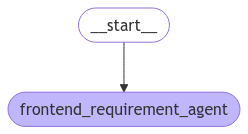

In [38]:
from IPython.display import Image

compiled_graph = graph.compile()
Image(compiled_graph.get_graph().draw_mermaid_png())

In [39]:
# Initial state with input requirements
initial_state = PrototypeState(
    input_requirements="A web application that allows users to register and view a dashboard with their profile details.",
    frontend_spec=None,
    backend_spec=None,
    frontend_code=None,
    backend_code=None,
    frontend_valid=False,
    backend_valid=False,
    frontend_feedback=None,
    backend_feedback=None,
    frontend_attempts=0,  # Initialize attempt counters
    backend_attempts=0
)

# Execute the graph
final_state = compiled_graph.invoke(initial_state, {"recursion_limit": 50})

In [40]:
import pprint
pprint.pprint(final_state)

{'backend_attempts': 0,
 'backend_code': None,
 'backend_feedback': None,
 'backend_spec': None,
 'backend_valid': False,
 'frontend_attempts': 0,
 'frontend_code': None,
 'frontend_feedback': None,
 'frontend_spec': '- Implement a responsive user registration form.\n'
                  '- Design a user-friendly login page with validation.\n'
                  '- Create a dashboard for users after they log in.\n'
                  '- Display user profile details on the dashboard.\n'
                  '- Ensure all pages are accessible and optimized for various '
                  'screen sizes.\n'
                  '- Incorporate interactive elements for better user '
                  'engagement.\n'
                  '- Use a consistent color scheme and typography across the '
                  'frontend.',
 'frontend_valid': False,
 'input_requirements': 'A web application that allows users to register and '
                       'view a dashboard with their profile details.'}
